# Building Deep Neural Networks with SAS DLPY


### Introduction

The following notebook demonstrates how to build Deep Neural Networks using SAS' DLPY action set in Visual Data Mining & Machine Learning (VDMML).  The DLPY action set is designed to have a similiar syntax to Keras.  Additionally, it's designed to easily transfer models from SAS to Keras and vice versa.  The data is from the CFAR-10 dataset, a labeled subset of 80 million tiny images, each 32x32x3. There are 10 classes of images:

<ul>
<li>airplane</li> 
<li>automobile</li>
<li>bird</li>
<li>cat</li>
<li>deer</li>
<li>dog</li>
<li>frog</li>
<li>horse</li>
<li>ship</li>
<li>truck</li>  

</ul>
The images were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.  To learn more, visit: https://www.cs.toronto.edu/~kriz/cifar.html

The architecture designed is a DenseNet-12.  The DenseNet paper by Gao Huang, Zhuang Liu, Laurens van der Maaten, and Killian Q. Weinberger can be found here: https://arxiv.org/pdf/1608.06993.pdf

For the DLPY package: https://github.com/sassoftware/python-dlpy

### Import Packages and connect to SAS Viya

In [1]:
import swat #1.5.0
from dlpy.images import * #DLPY version 0.7
from dlpy.splitting import two_way_split
from dlpy.applications import *
from dlpy.utils import upload_astore
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
s = swat.CAS(hostname='cascontroller.hlsrwe.sashq-d.openstack.sas.com', port=5570)

### Load the CIFAR-10 images into CAS

The training images to be loaded into memory are stored in the following location: /home/viyademo01/casuser/imagedata. There are 10 subfolders, one for each category listed above,that are named with the label that is to be attached to each image. For example, all the bird images live in /home/viyademo01/casuser/imagedata/bird. CAS will assign the subfolder, bird, as a label to each image in this location to be used as a target in our DNN.

In [3]:
imagedata = ImageTable.load_files(s, path='imagedata')

### Examine the first 5 rows of the dataset

In [4]:
imagedata.sample(5).head()

,_image_,_label_,_filename_0,_id_
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,bird,44767.png,13875
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,bird,44511.png,13844
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,bird,6210.png,14560
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,frog,4787.png,34187
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,horse,9742.png,39979


### Summarize images

In [5]:
imagedata.image_summary

jpg                 50000
minWidth               32
maxWidth               32
minHeight              32
maxHeight              32
meanWidth              32
meanHeight             32
mean1stChannel    113.865
min1stChannel           0
max1stChannel         255
mean2ndChannel     122.95
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    125.307
min3rdChannel           0
max3rdChannel         255
dtype: object

### Visualize 15 random images


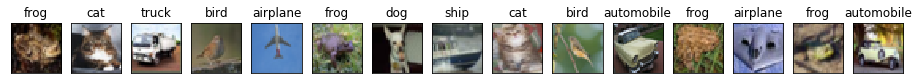

In [6]:
imagedata.show(nimages=15, ncol=15, randomize=True)

### Create a train and validation dataset

In [7]:
imagedata_train, imagedata_valid = two_way_split(imagedata, test_rate=5, seed=1985)

### Build a DenseNet-12 Neural Network

We will use actions from CAS' DLPY package to build a DenseNet-12 DNN.  Densenet is a prebuilt model in DLPY; when the model type is specified - the model will auto-populate all the layers.  Afterwards the fit function will train the actual model.  Pay close attention to how similiar this model is to Keras syntax.

<img src='https://raw.githubusercontent.com/jessebehrens/SASExamples/master/Viya/DeepNeuralNetworks/data/DenseNetDiagram.JPG' alt='DenseNet-12'>

## Build the model

DenseNet is a prebuilt model in SAS DLPY.  Therefore, we just have to call it once and the layer specifications will be automatically loaded.

In [8]:
DNN=DenseNet_Cifar(s, model_table='DenseNet12')

NOTE: Input layer added.
NOTE: Convolutional layer added.
NOTE: A block of layers added.
NOTE: Batch Normalization layer added.
NOTE: Convolutional layer added.
NOTE: Pooling layer added.
NOTE: A block of layers added.
NOTE: Batch Normalization layer added.
NOTE: Convolutional layer added.
NOTE: Pooling layer added.
NOTE: A block of layers added.
NOTE: Batch Normalization layer added.
NOTE: Convolutional layer added.
NOTE: Pooling layer added.
NOTE: A block of layers added.
NOTE: Batch Normalization layer added.
NOTE: Pooling layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


### Visualize the model architecture

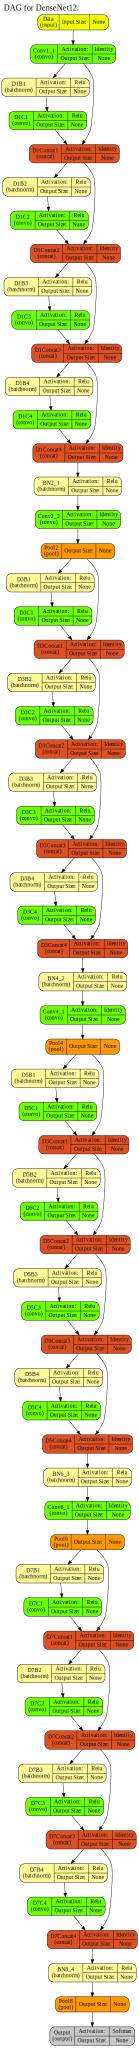

In [9]:
DNN.plot_network()

### Train the Model

In [10]:
DNNTrain=DNN.fit(data=imagedata_train, max_epochs=64, log_level=2, targetOrder='ascending',
                 optimizer={'algorithm':{'method':'momentum','stepsize':30,'lrpolicy':'step','clipgradmin':-1000, 
                                         'clipgradmax':1000} , 
                            'dropout':0.2, 'regL2':0.0005} )

NOTE: Training from scratch.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 570330.
NOTE:  The approximate memory cost is 223.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.37 (s).
NOTE:  The total number of workers is 3.
NOTE:  The total number of threads on each worker is 16.
NOTE:  The total mini-batch size per thread on each worker is 1.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 48.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:     10
NOTE:  Levels for the target variable:
NOTE:  Level      0: airplane  
NOTE:  Level      1: automobile
NOTE:  Level      2: bird      
NOTE:  Level      3: cat       
NOTE:  Level      4: deer      
NOTE:  Level      5: dog       
NOTE:  Level      6: frog      
NOTE:  Level      7: horse     
NOTE:  Level      8: ship      
NOTE:  Level      9: truck     
NOTE:  Number of input variables:     1
N

### Model Info

In [11]:
DNNTrain.ModelInfo

,Descr,Value
0,Model Name,densenet12
1,Model Type,Convolutional Neural Network
2,Number of Layers,62
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,20
6,Number of Pooling Layers,4
7,Number of Fully Connected Layers,0
8,Number of Batch Normalization Layers,20
9,Number of Concat Layers,16


### Plot the loss and fit error for the training history

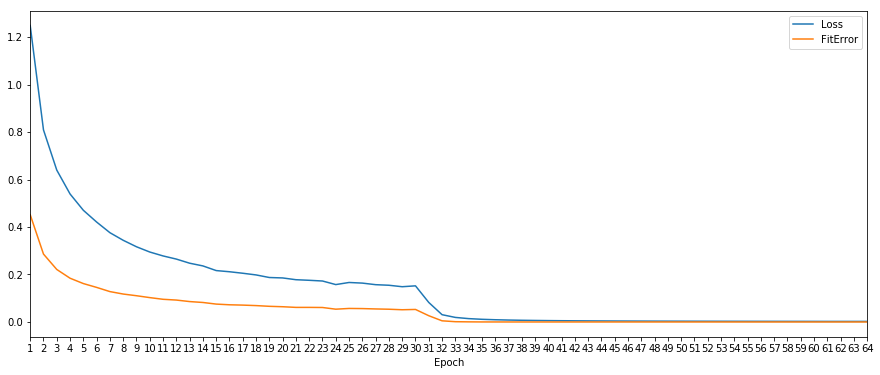

In [12]:
DNN.plot_training_history(fig_size=(15, 6))

### Return fit statistics for train dataset

In [13]:
DNN.predict(data=imagedata_train)

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read         47500
 1  Number of Observations Used         47500
 2  Misclassification Error (%)      0.044211
 3                   Loss Error      0.005259

[OutputCasTables]

             casLib              Name   Rows  Columns  \
 0  CASUSER(jebehr)  Valid_Res_3KGv0c  47500       17   
 
                                             casTable  
 0  CASTable('Valid_Res_3KGv0c', caslib='CASUSER(j...  

+ Elapsed: 44.5s, user: 914s, mem: 2.09e+03mb

### Return fit statistics for validation dataset

The results plus the model assesment graphs above will help provide guidance on how best to fine tune the model.

In [14]:
DNN.predict(data=imagedata_valid)

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          2500
 1  Number of Observations Used          2500
 2  Misclassification Error (%)         12.96
 3                   Loss Error      0.553439

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(jebehr)  Valid_Res_1sB4Gv  2500       17   
 
                                             casTable  
 0  CASTable('Valid_Res_1sB4Gv', caslib='CASUSER(j...  

+ Elapsed: 2.89s, user: 49.5s, mem: 2.04e+03mb

### Create a heat analysis of two random images 

Running prediction ...
... finished running prediction
NOTE: The number of images in the table is too large, only 2 randomly selected images are used in analysis.
NOTE: Table SAMPLE_TBL_EUTVTO contains compressed images.


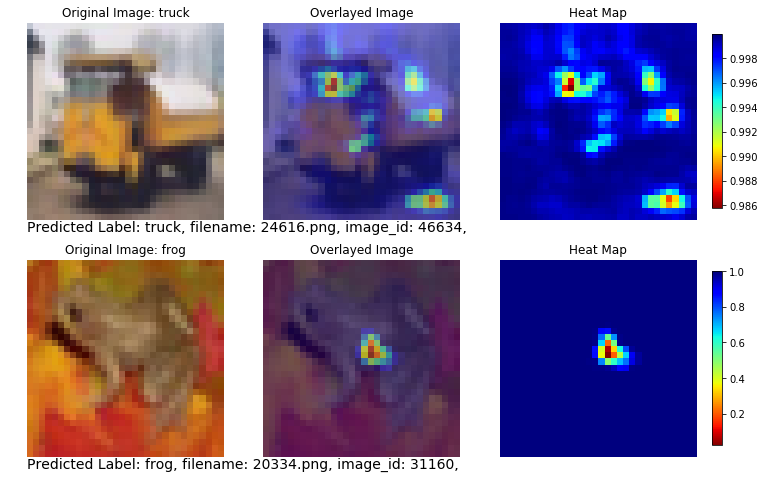

,I__label_,P__label_airplane,P__label_automobile,P__label_bird,P__label_cat,P__label_deer,P__label_dog,P__label_frog,P__label_horse,P__label_ship,P__label_truck,_filename_0,_id_,_image_,_label_,heat_map
0,truck,5.084756e-05,1.017291e-04,2.364676e-07,4.399215e-06,2.516404e-07,5.534989e-07,2.395429e-07,5.171036e-06,3.261411e-07,9.998362e-01,24616.png,46634,<PIL.PngImagePlugin.PngImageFile image mode=RG...,truck,"[[0.999564111233, 0.999531716108, 0.9994574189..."
1,frog,2.017929e-11,3.075100e-09,5.872843e-09,1.776115e-07,6.004303e-11,2.757909e-07,9.999995e-01,6.741541e-11,1.580934e-10,1.195290e-10,20334.png,31160,<PIL.PngImagePlugin.PngImageFile image mode=RG...,frog,"[[0.999999880791, 0.999999940395, 0.9999999403..."


In [15]:
DNN.heat_map_analysis(data=imagedata_train, mask_width=2, mask_height=2, step_size=1, max_display=2)

### Retrieve the feature map for the filters on layer 1 for a random truck image

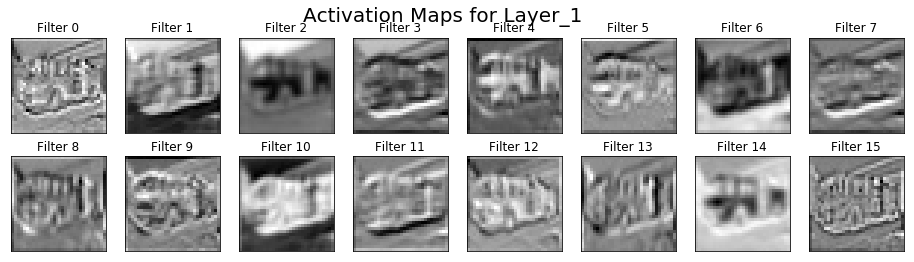

In [16]:
DNN.get_feature_maps(data=imagedata_train, label='truck')
DNN.feature_maps.display(layer_id=1)

### Load Test Data

This data has never been seen by the model before.  It will provide a good measure of how our model generalizes.

In [17]:
imagedata_test = ImageTable.load_files(s, path='testimagedata')

Bring the test results back and use scikit learn to plot a confusion matrix of the results.  The orginal confusion matrix code is provided here: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

### Bring the scored test table back to use pyplot on

In [18]:
testdata=DNN.predict(data=imagedata_test)
imagedata_test_scored=s.CASTable(testdata.OutputCasTables.Name[0])

In [19]:
testimagedatascored_py=imagedata_test_scored.to_frame()

In [20]:
target_dict=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

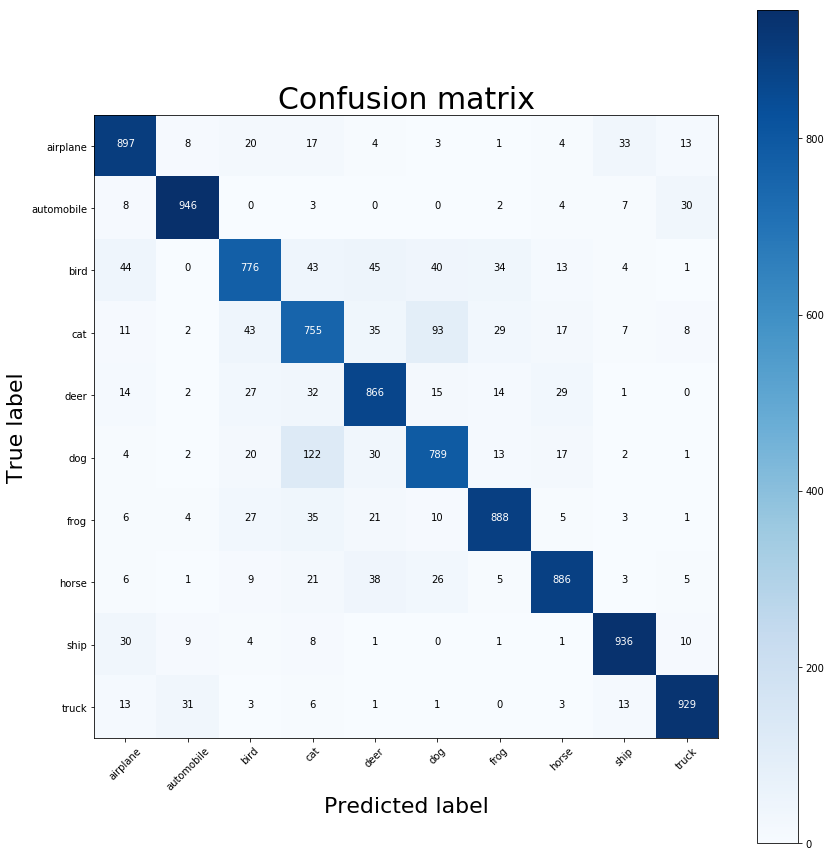

In [21]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(target_dict))
    plt.xticks(tick_marks, target_dict, rotation=45)
    plt.yticks(tick_marks, target_dict)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=22)
    plt.xlabel('Predicted label',fontsize=22)

# Compute confusion matrix
cnf_matrix = confusion_matrix(testimagedatascored_py['_label_'], testimagedatascored_py['I__label_'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')
plt.show()

### Export the model as an astore file

Astore files are binary files that allow models to be deployed and score on a variety of systems such as databases or SAS platforms.

In [22]:
DNN.deploy(path='/home/sas', output_format='astore')

NOTE: Model astore file saved successfully.


# Machine Learning or Machine Training?

We've built a DenseNet-12 CNN.  To demonstrate the limits of 'machine learning,' we will feed the model three new images it's never seen. <ol><li>Hotdogs</li> <li>Bill Murray</li> <li>The Stanley Cup</li><li>A Last Name</li></ol>

Let's see how machine learning classifies these three images

### Import the three data images

In [23]:
mlimages=ImageTable.load_files(s, path='mlimages')

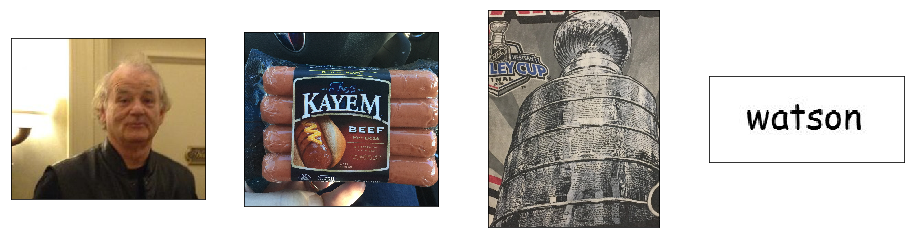

In [24]:
mlimages.show()

### Resize the images to 32x32 for the DenseNet

In [25]:
mlimages.resize(32,32)
mlimages.image_summary

jpg                     4
minWidth               32
maxWidth               32
minHeight              32
maxHeight              32
meanWidth              32
meanHeight             32
mean1stChannel     131.29
min1stChannel           0
max1stChannel         255
mean2ndChannel    141.561
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    151.205
min3rdChannel           0
max3rdChannel         255
dtype: object

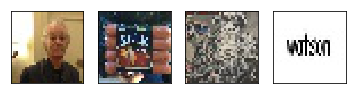

In [26]:
mlimages.show(figsize=(6,6))

In [27]:
with open('/home/sas/DenseNet12.astore', mode='rb') as file: 
    fileContent = file.read()
store_ = swat.blob(fileContent)
s.astore.upload(rstore={'caslib':'public','name':'DenseNet12'},store = store_)

[key]

 '3516BA1106831C111F03E42014FE4F0029320B30'

+ Elapsed: 0.123s, user: 0.174s, mem: 13.5mb

We gave our machine very common objects; however, it was not able to classify it to anything outside of what we have trained it to do. I believe this demonstrates how 'Machine Learning' is still a buzzword. Any great problem requires a great analyst behind it!!

In [28]:
mlimages_scored=s.CASTable(str(mlimages)[12:-2])
s.aStore.score(table={'name': mlimages_scored},
               casout={'name':'MLImage_scored', 'replace':True},
               copyVars='_filename_0',
               rstore={'caslib':'public','name':'DenseNet12'})

[OutputCasTables]

             casLib            Name  Rows  Columns  \
 0  CASUSER(jebehr)  MLImage_scored     4       12   
 
                                             casTable  
 0  CASTable('MLImage_scored', caslib='CASUSER(jeb...  

[Timing]

 Task Timing
 
                  Task   Seconds   Percent
 0   Loading the Store  0.097063  0.077256
 1  Creating the State  1.088193  0.866132
 2             Scoring  0.071118  0.056605
 3               Total  1.256382  1.000000

+ Elapsed: 1.61s, user: 3.85s, mem: 2.17e+03mb

In [29]:
s.CASTable('MLImage_scored')[['_filename_0','I__label_']].head()

,_filename_0,I__label_
0,BillMurray.jpg,cat
1,hotdog.JPG,truck
2,StanleyCup.JPG,frog
3,word.JPG,truck


### Sign out of CAS

In [30]:
s.session.endsession()

+ Elapsed: 0.015s, user: 0.0101s, mem: 0.798mb